In [71]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from tools.cbook import pickle2Obj
import tools
from tools.FV3_tools import read_solo_fields
from tools.CM1_tools import read_cm1_fields

from pltbook import nice_clevels, nice_mxmnintvl, container, plot_contour_row, find_max_index_ND

import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]

_nthreads = 2

# draw filled contours.
wclevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70]

tclevs = list(-40.0 + 2*np.arange(41))

pclevs = list(100*(-15.0 + np.arange(31)))

dclevs = list(-20.0 + np.arange(41))

zlevels = 10.0 + 50.*np.arange(300)

# Paths
paths = {}
paths['cm1_squall']  = '/work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06'
paths['solo_squall'] = '/work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV13/S06'

# paths['solo_bubble'] = '/work/wicker/climate_runs/FV3_Solo/bubble/1km/QV15'
# paths['cm1_bubble']  = '/work/wicker/climate_runs/cm1r20.3/run/bubble/1km/QV15'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
models = {}
for key in paths:
    print("Reading: ",key)
    if key[0:3] == 'cm1':
        models[key] = ( read_cm1_fields(paths[key], vars = ['pert_th'], zinterp=zlevels, file_pattern=None, ret_dbz=False, ret_ds=False) )
    if key[0:4] == 'solo':
        models[key] = ( read_solo_fields(paths[key], vars = ['theta_IC'], zinterp=zlevels, file_pattern=None, ret_dbz=False, ret_ds=False) )

Reading:  cm1_squall
------------------------------------------------------------------------------------------------------------------------
 Now reading... /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06/cm1out.nc
 Completed reading in:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06/cm1out.nc

 Interpolating fields to single column z-grid: /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06/cm1out.nc 

 Finished interp fields to single column z-grid:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06 

Reading:  solo_squall
------------------------------------------------------------------------------------------------------------------------
 Now reading... /work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV13/S06/atmos_hifreq.nc
 Completed reading in:  /work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV13/S06/atmos_hifreq.nc

 Interpolating fields to single column z-grid: /work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV13/S06/atmo

### CROSS Section of 3 KM Squall line init

127
2.9472947
2.9480226
Solo TH MAX: 2.9472947120666504
CM1  TH MAX: 2.9480226039886475
-0.0012775064


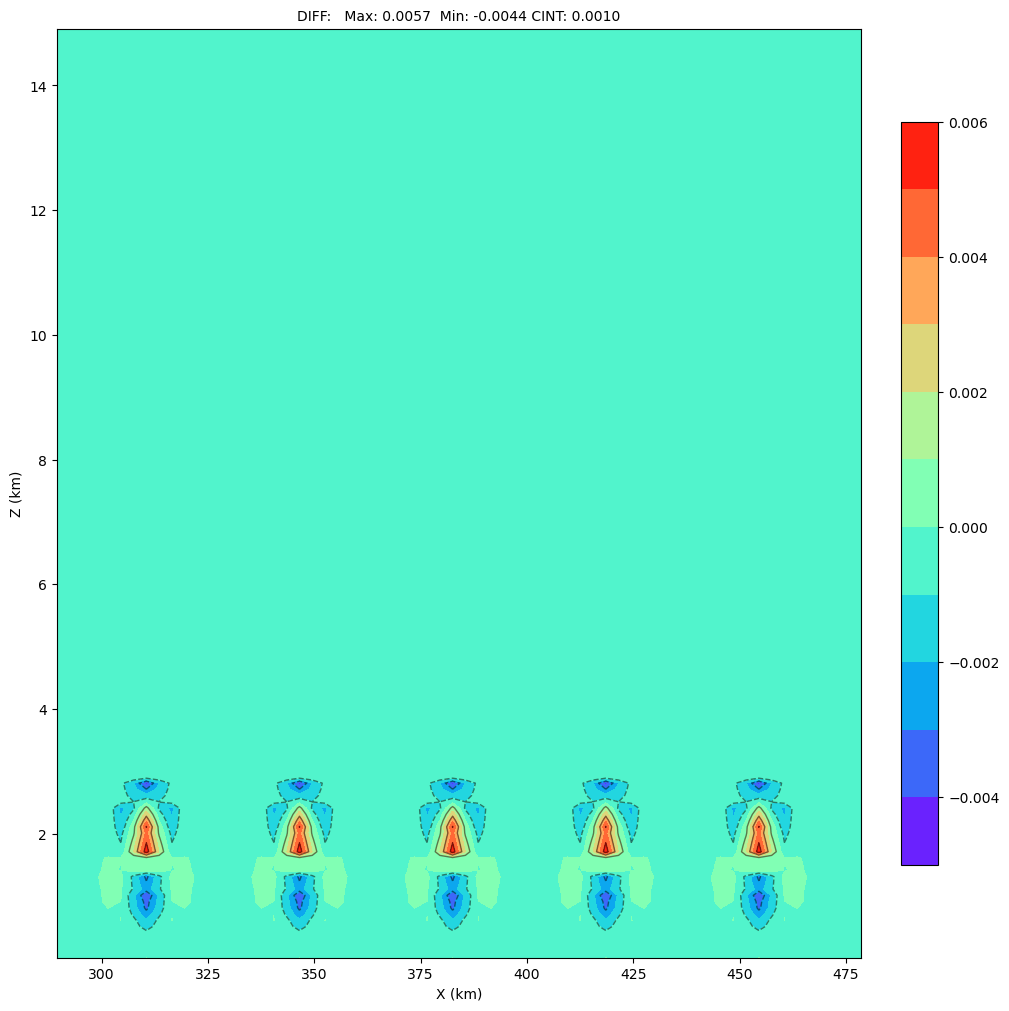

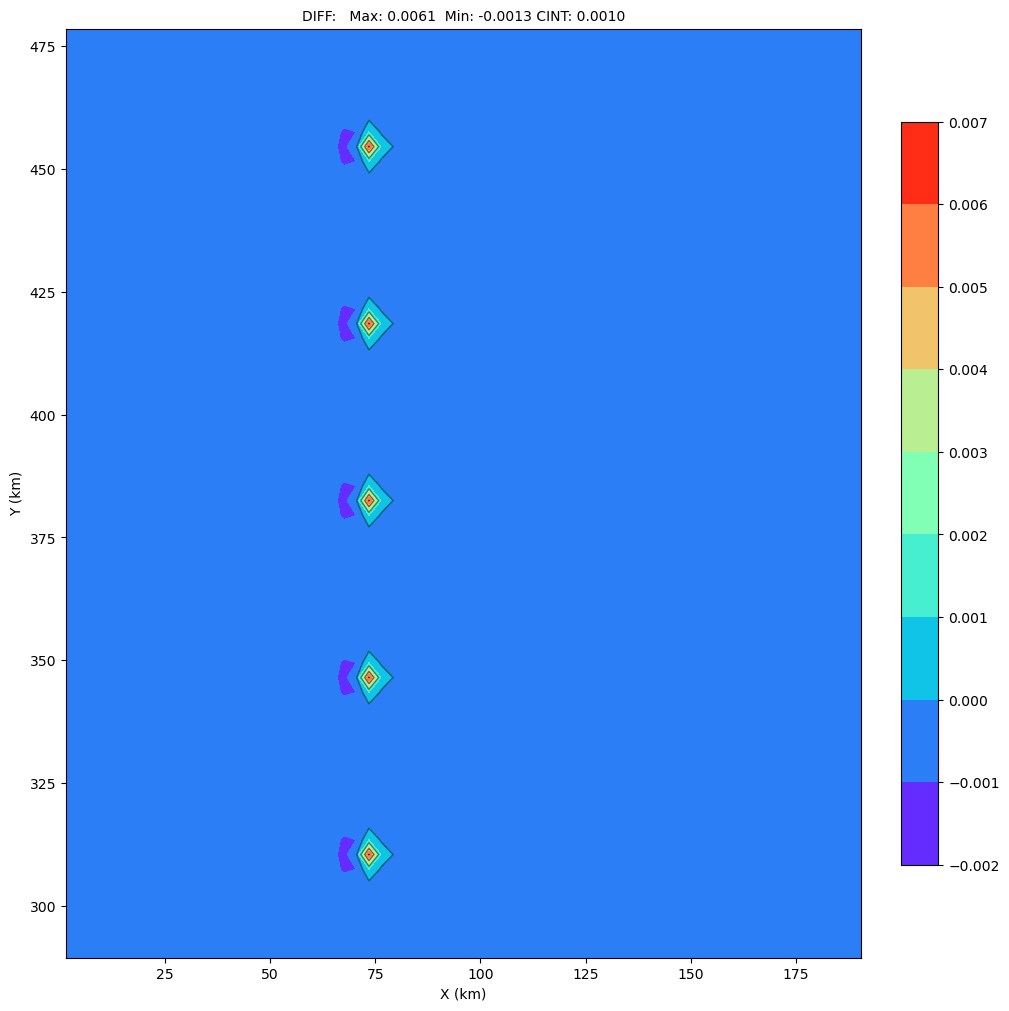

In [70]:
solo = models['solo_squall']
cm1  = models['cm1_squall']

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.

ny2 = (xc.shape[0]//2) - 1

print(ny2)

zsum = 100

print(solo['theta_IC'].max())
print(cm1['pert_th'][0].max())

clevs = list(-3. + 0.25*np.arange(25))

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.
yc    = cm1['yc']/1000.

ny2 = (xc.shape[0]//2) - 1

klevel = 25

print(f"Solo TH MAX: {solo['theta_IC'].max()}")
print(f"CM1  TH MAX: {cm1['pert_th'][0].max()}")

# fields = []
# fields.append(container(cm1['pert_th'][0,:,96:160,23], xc[96:160], zlevels/1000.))
# fields.append(container(solo['theta_IC'][:,96:160,23], xc[96:160], zlevels/1000.))
# plot_contour_row(fields, ptitle=['CM1', 'SOLO'], title='BUBBLE', xlabel='X (km)', ylabel='Z (km)',  cmap=plt.cm.rainbow, cint=0.25, mask_lt=0.1);

# plt.savefig(f"Initial_Condition_XZ_3km.png")

# klevel = 10

# fields = []
# fields.append(container(cm1['pert_th'][0,klevel,96:160,0:64], xc[96:160], yc[0:64]))
# fields.append(container(solo['theta_IC'][klevel,96:160,0:64], xc[96:160], yc[0:64]))
# plot_contour_row(fields, ptitle=['CM1', 'SOLO'], title='BUBBLE', xlabel='X (km)', ylabel='Y (km)', cmap=plt.cm.rainbow, cint=0.25, mask_lt=0.1);

# plt.savefig(f"Initial_Condition_XY_K10_3km.png")

fields = []
fields.append(container(cm1['pert_th'][0,:,96:160,23]-solo['theta_IC'][:,96:160,23], xc[96:160], zlevels/1000.))
plot_contour_row(fields, ptitle=['DIFF'], title='BUBBLE', xlabel='X (km)', ylabel='Z (km)',  cmap=plt.cm.rainbow, cint=0.001)


fields = []
fields.append(container(cm1['pert_th'][0,klevel,96:160,0:64]-solo['theta_IC'][klevel,96:160,0:64], xc[96:160], yc[0:64]))
plot_contour_row(fields, ptitle=['DIFF'], title='BUBBLE', xlabel='X (km)', ylabel='Y (km)', cmap=plt.cm.rainbow, cint=0.001);

print((cm1['pert_th'][0,klevel,96:160,0:64]-solo['theta_IC'][klevel,96:160,0:64]).min())



#### CROSS Section of 1 KM Squall line init

In [158]:
cm1   = '/work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06'
solo  = '/work/wicker/climate_runs/FV3_Solo/squall/euler/1km/QV16/S06'

models['cm1']  = ( read_cm1_fields(cm1,  vars = ['pert_th'], zinterp=zlevels, file_pattern=None, ret_dbz=False, ret_ds=False) )
models['solo'] = ( read_solo_fields(solo, vars = ['theta_IC'], zinterp=zlevels, file_pattern=None, ret_dbz=False, ret_ds=False) )


------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06/cm1out.nc 

 Completed reading in:  /work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06/cm1out.nc 

------------------------------------------------------------------------------------------------------------------------
 Interpolating fields to single column z-grid:  /work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06/cm1out.nc 

 Finished interp fields to single column z-grid:  /work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06/cm1out.nc 

-----------------------------------------------------------------------------------------------------------

In [1]:
solo = models['solo']
cm1  = models['cm1']

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.

ny2 = (xc.shape[0]//2) - 1

print(ny2)

zsum = 100

print(solo['theta_IC'].max())
print(cm1['pert_th'][0].max())

clevs = list(-3. + 0.25*np.arange(25))

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.
yc    = cm1['yc']/1000.

ny2 = (xc.shape[0]//2) - 1

klevel = 25

print(f"Solo TH MAX: {solo['theta_IC'].max()}")
print(f"CM1  TH MAX: {cm1['pert_th'][0].max()}")

fields = []
fields.append(container(cm1['pert_th'][0,:,288:480,71], xc[288:480], zlevels/1000.))
fields.append(container(solo['theta_IC'][:,288:480,71], xc[288:480], zlevels/1000.))
plot_contour_row(fields, ptitle=['CM1', 'SOLO'], title='BUBBLE', xlabel='X (km)', ylabel='Z (km)', cmap=plt.cm.viridis_r, cint=0.25);

plt.savefig(f"Initial_Condition_XZ_1km.png")

klevel = 12

fields = []
fields.append(container(cm1['pert_th'][0,klevel,288:480,0:192], xc[288:480], yc[0:192]))
fields.append(container(solo['theta_IC'][klevel,288:480,0:192], xc[288:480], yc[0:192]))
plot_contour_row(fields, ptitle=['CM1', 'SOLO'], title='BUBBLE', xlabel='X (km)', ylabel='Y (km)', cmap=plt.cm.viridis_r, cint=0.25);

plt.savefig(f"Initial_Condition_XY_K12_1km.png")

NameError: name 'models' is not defined